# 1_Preprocessing

1. Ingesting Learning outcomes.
2. Ingesting run details from live courses
3. Merging tables 1 and 2.
4. Preprocessing 4.

#### Context

The main purpose of the project is to preprocess course data available to our warehouse to extract out content description for each course, which is to be used for computing embeddings. Embeddings will be imrpoved when we use the following preprocessing steps: 
- lowercase all text to improve normalization
- remove stop words to reduce noise and dimentionality
- remove punctuationto improve normalization

#### Stakeholders

Will, Oana, Vitaly, Tomek

#### Additional Information

Project: Course Universe

Author: Andria Ellis 

Github Repository: https://github.com/andria-ellis/course_universe

Google Drive: https://drive.google.com/drive/folders/1FNyIJfeG-U31gJQXBmSUMSWqh6sg3Eti?usp=drive_link

Confluence: https://futurelearn-8324083.atlassian.net/wiki/spaces/DA/pages/416153601/Course+Universe


# Executive summary

3 Inputs, Learning Outcomes, Course Syllabus and Courses Live On-Site, comes from 2 different sources. Learning Outcomes and Course Syllabus contains the CDP text content, which is produced by Data Engineer Rob MacKinnon. It is automatically generated from all live CDPs. Courses Live On-Site is generated by me using SQL to find all live runs of short-courses amd bring through all variables from courses and runs table. 


#### These are the DataFrame column names that make up the final text embedding and what they correspond to on a CDP page:

'INTRODUCTION' (introduction sentence)
'course_syllabus' (Topics covered in the course)
'outcome_text' (What does the learner get out of the course)
'PROMOTED_RUN_TITLE' (The name of the course as observed by a learner)

### Preprocessing Steps

Removing stop words from text before generating text embeddings can be beneficial for several reasons:
* Reducing Noise and Improving Semantic Representation: Stop words are common words that occur frequently in a language but often do not carry significant semantic meaning (e.g., "the," "is," "and"). By removing stop words, you filter out noise from the text data, allowing the embedding model to focus more on the content-bearing words that contribute to the semantic representation of the text.
* Reducing Dimensionality: Stop words often contribute to the high dimensionality of the embedding space without providing significant value for downstream tasks. By removing them, you reduce the number of unique tokens in the text, which can lead to a more compact and efficient representation space. This reduction in dimensionality can improve the model's ability to generalize and handle large-scale text data more effectively.
* Enhancing Computational Efficiency: Stop words are frequently encountered in text data and may contribute to increased computational overhead during training and inference processes. By removing them, you reduce the computational burden on the embedding model, allowing for faster training and inference times, especially when dealing with large datasets or resource-constrained environments.
* Improving Similarity Measurement: Stop words can introduce noise in similarity measurements between texts, as their presence may artificially inflate the similarity score between documents. By eliminating stop words, you ensure that the similarity calculation focuses on the content-bearing words, leading to more accurate comparisons and clustering of text data.

Overall, removing stop words before generating text embeddings helps improve the quality, efficiency, and interpretability of the embeddings by emphasizing meaningful content while reducing noise and computational overhead. This pre-processing step is commonly used in natural language processing tasks to enhance the performance of text-based models and algorithms.

---

## Data used
List here files used and where they can be accessed:


---

## Data generated
List here any files (pickle, csv) that are created within this notebook:
* [df_runs_course_selection.pickle](https://drive.google.com/file/d/1zZH6fqS3oiiyLtLIc36woWjuc4-PvTv6/view?usp=drive_link)

Note: to be placed in ./data

---

In [37]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install missingno

In [38]:
import openai
import os
import pandas as pd
from tqdm import tqdm
import string
import nltk
from nltk.corpus import stopwords
import re
import missingno as msno

In [39]:
LEARNING_OUTCOMES_FILEPATH = "learning_outcomes_202403261629.csv"
AE_courses_filepath="courses_live_onsite.csv"
course_syllabus = pd.read_csv('run_details_202403271517.csv')

In [40]:
## The learning outcomes and course syllabus files are provided by data engineer Rob Mackinnon. Currently there is no ability for analysts to download 
## this data ourselves.
## Run number is how learning_outcomes is linked to the data we get from the warehouse. The run numebr in learning_outcomes matches 
## the number number stored in natural_key

run_details = pd.read_csv(AE_courses_filepath)
run_details['run_id'] = run_details['RUN_ID'].str.replace('Run:', '').astype(int)


In [41]:
tqdm.pandas(ncols=100)

In [42]:
run_details.shape

(1405, 137)

In [43]:
#Combinning learning outcomes for each run and then merging with the rest of run details

learning_outcomes = pd.read_csv(LEARNING_OUTCOMES_FILEPATH)
learning_outcomes = learning_outcomes[learning_outcomes["linkable_type"] == "Run"]
learning_outcomes = learning_outcomes.groupby("linkable_id")["outcome_text"]\
    .apply(lambda x: ".".join(x))\
    .reset_index()\
    .rename(columns={"linkable_id": "run_id"})
    
df_run_details = pd.merge(
    left = run_details,
    right = learning_outcomes,
    on = "run_id",
    how="inner"
)
df_run_details.shape


(1399, 138)

In [44]:
#Combinning learning outcomes for each run and then merging with the rest of run details

course_syllabus = pd.read_csv('run_details_202403271517.csv')
    
df_run_details = pd.merge(
    left = df_run_details,
    right = course_syllabus,
    on = "run_id",
    how="inner"
)
df_run_details.shape


(1399, 149)

In [45]:
df_run_details = df_run_details.convert_dtypes()

# Checking if we have duplicates
(df_run_details.shape, 
df_run_details.drop_duplicates(subset=["NATURAL_KEY"]).shape)

# topics extraction

# for individual lines
topics_series = pd.Series(df_run_details.iloc[1].TOPICS.split("\""))
topics_series[~ topics_series.str.contains('\n')].to_list()



['Biology & Biotechnology', 'Food Tech', 'Agriculture']

In [46]:
def extract_brackets(row):
    return row.split('(', 1)[1].split(')')[0].strip()

In [47]:
# for all
def extract_topics(row) -> [str]:
    topics_series = pd.Series(row.split("\""))
    return topics_series[~ topics_series.str.contains('\n')].values

In [48]:
# replace these values with 'na' text

values = {"TOPICS": 'na'}
df_run_details = df_run_details.fillna(value=values)

# replace missing first category values with 'na' string
values = {"FIRST_CATEGORY": 'na'}
df_run_details = df_run_details.fillna(value=values)

df_run_details["TOPICS_ARRAY"] = df_run_details["TOPICS"].apply(extract_topics)

In [49]:
# reset index
df_run_details.reset_index(inplace=True)

In [50]:
# drop 'index' column
df_run_details.drop(columns=['index','TOPICS'],inplace=True)
df_run_details.tail(3)

,ID,NATURAL_KEY,COURSE_ID,SLUG,IS_COURSE_RETIRED,IS_COURSE_PUBLISHED,PROMOTED_RUN_TITLE,ORGANISATION_DIMENSION_ID,ORGANISATION_SLUG,ORGANISATION_TITLE,...,outline,technical_requirements,requirements,meta_title,meta_description,promoted_co_branding_organisation_text,course_syllabus,project_lead_notified,syllabus_enabled,TOPICS_ARRAY
1396,5c5a93a042235058b1ef7b0ac1e11b67,Course:6c877b2e6019cad45595192f37f33857289bca8...,7036,health-promotion,False,True,Capacity Building: Core Competencies for Healt...,114,taipei-medical-university,Taipei Medical University,...,"With the increased life-expectancy, living a h...",<NA>,This course is for any students who are intere...,Capacity Building for Health Promotion - Onlin...,A health promotion research of how behavioral ...,<NA>,"- Program Planning, Implementation, and Evalua...",0,0,"[Leadership in Healthcare, Nursing, Care, Heal..."
1397,ffa4eb0e32349ae57f7a0ee8c7cd7c11,Course:238ddade939a0998bc6b06bb0a3117ff50a23ba...,10065,living-with-deafness-and-hearing-impairment,False,True,Living with Deafness and Hearing Impairment,2,university-of-east-anglia,UEA (University of East Anglia),...,"According to the World Health Organization, mo...",<NA>,This course is designed for anyone interested ...,Living with Deafness and Hearing Impairment - ...,Understand the causes and impacts of deafness ...,<NA>,* Defining deafness and hearing impairment * ...,0,1,[Disability]
1398,c12d1f7cc7c4b41a125b5752d1238b03,Course:ed6c4946a449962e9556f54f50889055756b689...,3993,food-science-and-nutrition,False,True,Food Science and Nutrition: From the Farm to You,6,university-of-leeds,University of Leeds,...,"On this course, you’ll learn how food science ...",<NA>,The course is part of the [Going to University...,Food Science and Nutrition - Online Course - F...,Get a fascinating insight into food science as...,<NA>,* The opportunities and challenges inherent in...,0,0,"[Nutrition, Food Tech, Agriculture]"


In [51]:
# check for nan values in the columns we are planning to use.
df_run_details.course_syllabus.isna().value_counts()

course_syllabus
False    1380
True       19
Name: count, dtype: int64

In [52]:
df_run_details.outcome_text.isna().value_counts()

outcome_text
False    1399
Name: count, dtype: int64

In [53]:
df_run_details.isnull().sum(axis=0).sort_values(ascending=False)

technical_requirements                    1256
SUBTITLE                                  1248
promoted_co_branding_organisation_text    1179
STRATEGIC_AREA.1                           776
STRATEGIC_AREA                             776
                                          ... 
IS_ENDED                                     0
STARTS_DATE                                  0
IS_STARTED                                   0
COURSE_ID.1                                  0
TOPICS_ARRAY                                 0
Length: 149, dtype: int64

In [54]:
df_run_details["INTRODUCTION"] = df_run_details["INTRODUCTION"].fillna("")
df_run_details["outline"] = df_run_details["outline"].fillna("")
df_run_details["outline_title"] = df_run_details["outline_title"].fillna("")
df_run_details["course_syllabus"] = df_run_details["course_syllabus"].fillna("")
df_run_details["requirements"] = df_run_details["requirements"].fillna("")
df_run_details["meta_title"] = df_run_details["meta_title"].fillna("")
df_run_details["meta_description"] = df_run_details["meta_description"].fillna("")
df_run_details["outcome_text"] = df_run_details["outcome_text"].fillna("")

In [55]:
def remove_undesirable_characters(str_): # This function removes punctuations and empty spaces
    str_ = re.sub('http[s]?://\S+', '', str_)
    str_ = re.sub(r"<.*>", "", str_)
    str_ = str_.replace("\n", "").replace("\r", "")
    str_ = re.sub(r"[-*+\\\"]", "", str_)
    str_ = str_ = re.sub(r"\s{2,}"," ", str_)
    str_ = str_.strip()
    return str_

df_run_details["INTRODUCTION"] = df_run_details["INTRODUCTION"].apply(remove_undesirable_characters)
df_run_details["outline"] = df_run_details["outline"].apply(remove_undesirable_characters)
df_run_details["outline_title"] = df_run_details["outline_title"].apply(remove_undesirable_characters)
df_run_details["course_syllabus"] = df_run_details["course_syllabus"].apply(remove_undesirable_characters)
df_run_details["requirements"] = df_run_details["requirements"].apply(remove_undesirable_characters)
df_run_details["meta_title"] = df_run_details["meta_title"].apply(remove_undesirable_characters)
df_run_details["meta_description"] = df_run_details["meta_description"].apply(remove_undesirable_characters)
df_run_details["outcome_text"] = df_run_details["outcome_text"].apply(remove_undesirable_characters)

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/var/folders/7v/l62ckmdx3djccmgd9b2y6yf80000gn/T/ipykernel_89536/2806111082.py:2: SyntaxWarning: invalid escape sequence '\S'
  str_ = re.sub('http[s]?://\S+', '', str_)


In [56]:
# check how this worked
df_run_details["outcome_text"]

0       Discuss NEB history and background.Describe NE...
1       Identify the different methods of plant biotec...
2       Explain the business value of data science.App...
3       demonstrate an understanding of ageing as a li...
4       Identify legal terminology as well as the lega...
                              ...                        
1394    Apply appropriate vocabulary in a different co...
1395    Discuss various definitions of the concepts of...
1396    Describe stages of the health promotion cycle....
1397    Identify the impact of deafness and hearing im...
1398    Explore the importance of food processing in t...
Name: outcome_text, Length: 1399, dtype: object

In [57]:
# another check
df_run_details['INTRODUCTION']

0       Discover how the New European Bauhaus is creat...
1       Build your knowledge of food production challe...
2       Build a solid foundation in data science and l...
3       Learn how to prepare cities to meet the needs ...
4       Learn how the GDPR helps to protect health dat...
                              ...                        
1394    Take your understanding of Thailand and its cu...
1395    Understand the role of medical peace work, and...
1396    Basic concepts of the core competencies for he...
1397    Understand the causes and impacts of deafness ...
1398    Follow food’s fascinating journey from the far...
Name: INTRODUCTION, Length: 1399, dtype: object

### Check the fields we would like to concatenate to represent a course

In [58]:
df_run_details[["PROMOTED_RUN_TITLE", "INTRODUCTION", "outcome_text"]].dtypes

PROMOTED_RUN_TITLE    string[python]
INTRODUCTION                  object
outcome_text                  object
dtype: object

In [59]:
# no
len(df_run_details[df_run_details["PROMOTED_RUN_TITLE"] == 'nan'])

0

These are the DataFrame column names and what they correspond to on a CDP page:
* 'INTRODUCTION' (introduction sentence)
* 'course_syllabus' (Topics covered in the course)
* 'outcome_text' (What does the learner get out of the course)
* 'PROMOTED_RUN_TITLE' (The name of the course as observed by a learner) 

In [60]:
# Concatenating all columns, i.e, concatenating intro, descriptions, etc into a single text block

def concatenate_series(series):
    columns = [
        "PROMOTED_RUN_TITLE", 
        "INTRODUCTION",
        "course_syllabus", 
        "outcome_text"
    ]
    return " ".join(series[columns].to_list())

df_run_details["concatenated_cdp_content"] = df_run_details.apply(concatenate_series, axis=1)
df_run_details.concatenated_cdp_content

0       The New European Bauhaus: Concept, Movement, a...
1       Improving Food Production with Agricultural Te...
2       Introduction to Data Science for Business Buil...
3       Inclusive Mobility for an Ageing Population Le...
4       Protecting Health Data in the Modern Age Learn...
                              ...                        
1394    Let’s Learn Thai Language: Basic Conversation ...
1395    Global Health, Conflict and Violence Understan...
1396    Capacity Building: Core Competencies for Healt...
1397    Living with Deafness and Hearing Impairment Un...
1398    Food Science and Nutrition: From the Farm to Y...
Name: concatenated_cdp_content, Length: 1399, dtype: object

In [61]:
lowercase_content=df_run_details["concatenated_cdp_content"].str.lower()

In [62]:
def remove_punctuation(input_string):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    result = input_string.translate(translator)

    return result

In [63]:
clean_data = []
for text in lowercase_content:
    # Remove punctuation using string.punctuation
    clean_text = ''.join(char for char in text if char not in string.punctuation)
    clean_data.append(clean_text)

# Convert the cleaned data back to a Series
clean_text_series = pd.Series(clean_data)


In [64]:
# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Loop through each element in the Series and remove stop words
clean_data = []
for text in clean_text_series:
    # Tokenize the text
    tokens = text.split()
    # Remove stop words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # Join the filtered tokens back into a sentence
    clean_text = ' '.join(filtered_tokens)
    clean_data.append(clean_text)

# Convert the cleaned data back to a Series
final_text = pd.Series(clean_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andriaellis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df_run_details["concatenated_cdp_content_final"]=final_text

In [66]:
#Converting the categories array from a text representation of a list to an actual list
df_run_details["CATEGORIES_ARRAY"] = (df_run_details["CATEGORIES"]
                                                    .str.strip("[]")
                                                    .str.replace("\n","")
                                                    .str.replace("\"", "")
                                                    .str.strip(" ")
                                                    .str.replace(r",\s+", ",", regex=True)
                                                    .str.split(",")
                                                    )

In [67]:
df_run_details.PROMOTED_RUN_TITLE

0       The New European Bauhaus: Concept, Movement, a...
1       Improving Food Production with Agricultural Te...
2               Introduction to Data Science for Business
3             Inclusive Mobility for an Ageing Population
4                Protecting Health Data in the Modern Age
                              ...                        
1394    Let’s Learn Thai Language: Basic Conversation ...
1395                 Global Health, Conflict and Violence
1396    Capacity Building: Core Competencies for Healt...
1397          Living with Deafness and Hearing Impairment
1398     Food Science and Nutrition: From the Farm to You
Name: PROMOTED_RUN_TITLE, Length: 1399, dtype: string

In [68]:
#Filtering out only relevant fields from 

df_run_details = df_run_details[[
                              "COURSE_SLUG",
                              "PROMOTED_RUN_TITLE",
                              "FIRST_CATEGORY",
                              "SECOND_CATEGORY",
                              "TOPICS_ARRAY",
                              "CATEGORIES_ARRAY",
                              "DIFFICULTY_LEVEL",
                              "concatenated_cdp_content",
                              "concatenated_cdp_content_final"]].rename(columns={
                                  "PROMOTED_RUN_TITLE":"COURSE_NAME"
                              })

In [69]:
df_run_details.head()

,COURSE_SLUG,COURSE_NAME,FIRST_CATEGORY,SECOND_CATEGORY,TOPICS_ARRAY,CATEGORIES_ARRAY,DIFFICULTY_LEVEL,concatenated_cdp_content,concatenated_cdp_content_final
0,new-european-bauhaus-concept-movement-and-oppo...,"The New European Bauhaus: Concept, Movement, a...",nature_and_environment,politics_and_society,"[European Union, Conservation, Urbanisation, E...","[Nature & Environment, Politics & Society]",Open,"The New European Bauhaus: Concept, Movement, a...",new european bauhaus concept movement opportun...
1,food-production-agricultural-technology-plant-...,Improving Food Production with Agricultural Te...,nature_and_environment,science_engineering_and_maths,"[Biology & Biotechnology, Food Tech, Agriculture]","[Nature & Environment, Science, Engineering & ...",Introductory,Improving Food Production with Agricultural Te...,improving food production agricultural technol...
2,introduction-to-data-science-for-business,Introduction to Data Science for Business,business_and_management,science_engineering_and_maths,"[Data Science, Data Analytics]","[Science, Engineering & Maths, Business & Mana...",Introductory,Introduction to Data Science for Business Buil...,introduction data science business build solid...
3,inclusive-mobility-for-an-ageing-population,Inclusive Mobility for an Ageing Population,politics_and_society,<NA>,"[Public Policy, Social Issues]",[Politics & Society],Intermediate,Inclusive Mobility for an Ageing Population Le...,inclusive mobility ageing population learn pre...
4,protecting-health-data,Protecting Health Data in the Modern Age,law,healthcare_medicine,"[GDPR, Medical Technology, Safeguarding, Healt...","[Law, Healthcare & Medicine]",Introductory,Protecting Health Data in the Modern Age Learn...,protecting health data modern age learn gdpr h...


In [70]:
df_run_details.COURSE_SLUG.value_counts()

COURSE_SLUG
new-european-bauhaus-concept-movement-and-opportunities    1
fundraising-for-non-fundraisers                            1
introduction-to-data-science-for-business                  1
inclusive-mobility-for-an-ageing-population                1
protecting-health-data                                     1
                                                          ..
let-s-learn-thai-language-2                                1
medical-peace-work-global-health                           1
health-promotion                                           1
living-with-deafness-and-hearing-impairment                1
food-science-and-nutrition                                 1
Name: count, Length: 1399, dtype: Int64

In [71]:
#df_runs_for_course_selection.to_excel("../data/df_runs_course_selection.xlsx")
df_run_details.to_pickle("df_run_details_280324.pickle")

### Extra code 

Below are code I wrote to analyze the data while writing this notebook. Feel free to play in the space below and explore the data

In [27]:
#df_run_details.sample(1)

,ID,NATURAL_KEY,COURSE_ID,SLUG,IS_COURSE_RETIRED,IS_COURSE_PUBLISHED,PROMOTED_RUN_TITLE,ORGANISATION_DIMENSION_ID,ORGANISATION_SLUG,ORGANISATION_TITLE,...,outline_title,outline,technical_requirements,requirements,meta_title,meta_description,promoted_co_branding_organisation_text,course_syllabus,project_lead_notified,syllabus_enabled
1295,15b3342aa0abd5176b93d68ddf95e3ce,Course:c4b246d3af6eca8ed35ee01c0f1c03a0eb5b998...,5834,mindfulness-focus-on-adolescents,False,True,Mindfulness: A Focus on Adolescents,18,university-of-glasgow,The University of Glasgow,...,NaN,##Support emotional wellbeing through mindfuln...,NaN,This course is for all professionals intereste...,Teaching Mindfulness to Children - Online Mind...,Discover mindfulness techniques for children t...,NaN,* The application and evidence base for mindfu...,1,0


In [28]:
#df_run_details.FIRST_CATEGORY.value_counts()

FIRST_CATEGORY
healthcare_medicine              300
business_and_management          264
nature_and_environment           124
it_and_computer_science           99
creative_arts_and_media           93
teaching                          87
science_engineering_and_maths     81
politics_and_society              77
language                          67
history                           63
psychology_and_mental_health      55
study_skills                      41
law                               34
literature                        13
Name: count, dtype: int64

((1399, 149), (1399, 149))

In [93]:
#df_run_details.SLUG.value_counts()

SLUG
new-european-bauhaus-concept-movement-and-opportunities    1
fundraising-for-non-fundraisers                            1
introduction-to-data-science-for-business                  1
inclusive-mobility-for-an-ageing-population                1
protecting-health-data                                     1
                                                          ..
let-s-learn-thai-language-2                                1
medical-peace-work-global-health                           1
health-promotion                                           1
living-with-deafness-and-hearing-impairment                1
food-science-and-nutrition                                 1
Name: count, Length: 1405, dtype: Int64

In [94]:
#df_run_details.groupby(["FIRST_CATEGORY","SECOND_CATEGORY"])["NATURAL_KEY"].count()

FIRST_CATEGORY           SECOND_CATEGORY              
business_and_management  creative_arts_and_media           9
                         healthcare_medicine               2
                         history                           1
                         it_and_computer_science          23
                         language                          1
                                                          ..
teaching                 nature_and_environment            3
                         politics_and_society             11
                         psychology_and_mental_health      3
                         science_engineering_and_maths     4
                         study_skills                      5
Name: NATURAL_KEY, Length: 124, dtype: int64

In [95]:
# interesting that we have NaN values, too...
#df_run_details.DIFFICULTY_LEVEL.value_counts(dropna=False)

DIFFICULTY_LEVEL
Introductory    742
Intermediate    295
Open            290
<NA>             42
Advanced         36
Name: count, dtype: Int64

array([[<Axes: title={'center': 'NUMBER_OF_STEPS'}>]], dtype=object)

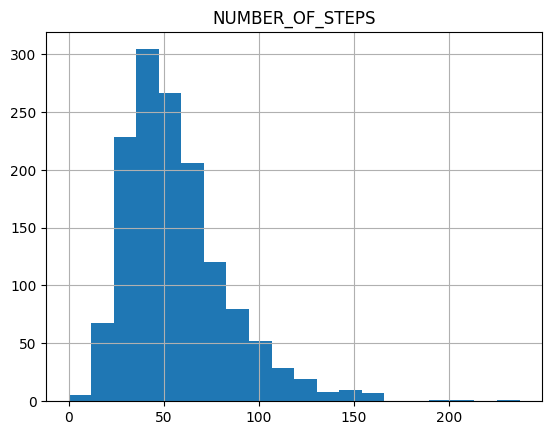

In [96]:
# rather strange that we have some more extreme number of steps in this dataset
#df_run_details[["NUMBER_OF_STEPS"]].hist(bins=20)

In [97]:
#df_run_details[["NUMBER_OF_STEPS"]].value_counts().sort_index()

NUMBER_OF_STEPS
0                  2
8                  1
9                  1
11                 1
12                 1
                  ..
159                1
162                3
192                1
212                1
237                1
Name: count, Length: 143, dtype: int64

In [98]:
#df_run_details[["NUMBER_OF_STEPS"]].describe()

,NUMBER_OF_STEPS
count,1405.0
mean,56.75089
std,27.329982
min,0.0
25%,38.0
50%,51.0
75%,70.0
max,237.0


In [99]:
#df_run_details[["NUMBER_OF_STEPS"]].mode()
# value that occurs most often

,NUMBER_OF_STEPS
0,46


In [100]:
#df_run_details[["NUMBER_OF_STEPS"]].median()
# middle value: 50 steps per typical course

NUMBER_OF_STEPS    51.0
dtype: Float64

In [101]:
#df_run_details.ORGANISATION_SLUG.value_counts(dropna=False)

ORGANISATION_SLUG
university-of-leeds                         74
futurelearn                                 49
taipei-medical-university                   45
universiti-malaya                           39
university-of-glasgow                       38
                                            ..
complutense-university-of-madrid             1
tavistock-institute-of-human-relations       1
good-loop                                    1
transformative-urban-mobility-initiative     1
tourettes-action                             1
Name: count, Length: 196, dtype: Int64

In [102]:
#df_run_details.ORGANISATION_SLUG.nunique()

196

['Biology & Biotechnology', 'Food Tech', 'Agriculture']